In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import category_encoders as ce
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import ConvLSTM2D, Dense, Flatten, Dropout, BatchNormalization, LeakyReLU, Reshape, Embedding, Concatenate, Input, Layer
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [2]:
df=pd.read_csv('C:/Users/vnsat/OneDrive/Desktop/M.Tech/Main Project/Final_Dataset_1-VNST.csv')

In [3]:
df.shape

(2666, 23)

In [4]:
for col in df.columns:
    print(f"{col}: {df[col].dtype}")

State: object
Account length: int64
Area code: int64
International plan: object
Voice mail plan: object
Number vmail messages: int64
Total day minutes: float64
Total day calls: int64
Total day charge: float64
Total eve minutes: float64
Total eve calls: int64
Total eve charge: float64
Total night minutes: float64
Total night calls: int64
Total night charge: float64
Total intl minutes: float64
Total intl calls: int64
Total intl charge: float64
Customer service calls: int64
Churn: bool
District: object
District_Code: object
Area: object


In [5]:
df.drop(['State','Customer service calls','District','District_Code','Area'],axis=1,inplace=True)

In [6]:
nan_counts = df.isnull().sum()
print("Columns with NaN values and their count:\n", nan_counts[nan_counts > 0])

Columns with NaN values and their count:
 Series([], dtype: int64)


In [7]:
def total_missing_count(col):
    is_real_nan = col.isnull().sum()
    is_fake_nan = col.astype(str).str.strip().str.lower().isin(['', 'nan', 'none', 'null','Nan','NaN']).sum()
    return is_real_nan + is_fake_nan

In [8]:
for col in df.select_dtypes(include='object').columns:
    count = total_missing_count(df[col])
    print(f"{col}: {count} total missing (real + fake)")

International plan: 0 total missing (real + fake)
Voice mail plan: 0 total missing (real + fake)


In [9]:
df['Total day minutes'] = df['Total day minutes'].astype('int64')
df['Total eve minutes'] = df['Total eve minutes'].astype('int64')
df['Total night minutes'] = df['Total night minutes'].astype('int64')
df['Total intl minutes'] = df['Total intl minutes'].astype('int64')

In [10]:
for col in df.select_dtypes(include='object').columns:
    print(df[col].value_counts())
    print("-" * 25)

International plan
No     2396
Yes     270
Name: count, dtype: int64
-------------------------
Voice mail plan
No     1933
Yes     733
Name: count, dtype: int64
-------------------------


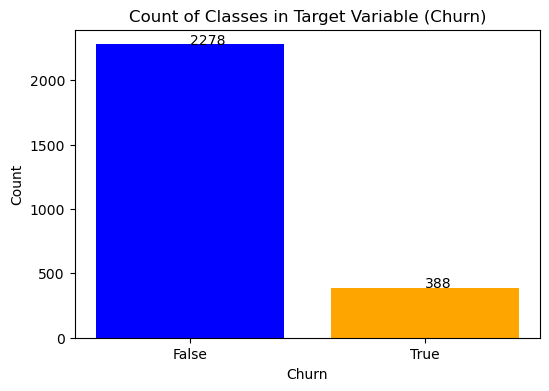

In [11]:
target_counts = df['Churn'].value_counts()
plt.figure(figsize=(6,4))
bars=plt.bar(target_counts.index.astype(str), target_counts.values, color=['blue', 'orange'])
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(bar.get_height()))
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Count of Classes in Target Variable (Churn)')
plt.show()

In [12]:
object_cols = df.select_dtypes(include='object').columns.tolist()
print(object_cols)
binary_encoder = ce.BinaryEncoder(cols=object_cols)
binary_encoded_df = binary_encoder.fit_transform(df[object_cols])
df = df.drop(columns=['International plan','Voice mail plan'])
df = pd.concat([df, binary_encoded_df], axis=1)

['International plan', 'Voice mail plan']


In [13]:
print(df['Churn'].unique())

[False  True]


In [14]:
df['Churn']=df['Churn'].astype(int)

In [15]:
X = df.drop(columns=['Churn'])
y = df['Churn']

In [16]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=36)
X_train_real, X_val_real, y_train_real, y_val_real = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=36)

In [17]:
print("Test set class distribution:", Counter(y_test))

Test set class distribution: Counter({0: 456, 1: 78})


In [18]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

In [19]:
pca = PCA()
pca.fit(scaled_data)

PCA()

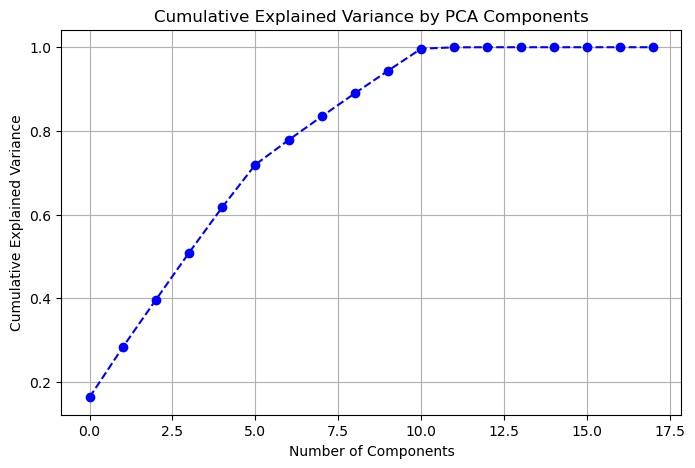

In [20]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [21]:
X_train_scaled = scaler.fit_transform(X_train_real)
X_val_scaled = scaler.transform(X_val_real)
X_test_scaled = scaler.transform(X_test)

In [22]:
n_components = 17
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [23]:
print(f"Shape of PCA components: {pca.components_.shape}")
print(f"Shape of X columns: {len(X.columns)}")

Shape of PCA components: (17, 18)
Shape of X columns: 18


In [24]:
components_df = pd.DataFrame(pca.components_, columns=X.columns)
top_features = components_df.abs().sum(axis=0).nlargest(n_components).index.tolist()
print("Top 10 Features after PCA:", top_features)

Top 10 Features after PCA: ['Total intl minutes', 'Total intl charge', 'Total eve minutes', 'Total eve charge', 'Total day minutes', 'Total day charge', 'Account length', 'Total night charge', 'Total night minutes', 'Total night calls', 'International plan_1', 'International plan_0', 'Total day calls', 'Total intl calls', 'Total eve calls', 'Number vmail messages', 'Voice mail plan_1']


In [25]:
smote = SMOTE(random_state=42)
X_augmented, y_augmented = smote.fit_resample(X_train_pca, y_train_real)

In [26]:
print("After SMOTE:", np.bincount(y_augmented))

After SMOTE: [1457 1457]


In [27]:
X_val_np = np.array(X_val_pca)
X_test_np = np.array(X_test_pca)

In [28]:
n_features = X_augmented.shape[1]
X_augmented = X_augmented.reshape((-1, 1, 1, n_features, 1))
X_val_real_reshaped = X_val_np.reshape((-1, 1, 1, n_features, 1))
X_test_aligned = X_test_np.reshape((-1, 1, 1, n_features, 1))

In [29]:
print("X_augmented shape:", X_augmented.shape)
print("y_augmented shape:", y_augmented.shape)

X_augmented shape: (2914, 1, 1, 17, 1)
y_augmented shape: (2914,)


In [30]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_augmented), y=y_augmented)
class_weight_dict = dict(enumerate(class_weights))

In [31]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1. - 1e-7)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return K.mean(-alpha * K.pow(1. - pt, gamma) * K.log(pt))
    return focal_loss_fixed

In [32]:
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        alpha = K.softmax(e, axis=1)
        context = x * alpha
        return K.sum(context, axis=1)


In [33]:
def convlstm_gwo_model():
    inp = Input(shape=(1, 1, n_features, 1))
    x = ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu')(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = AttentionLayer()(x)
    x = Flatten()(x)
    
    x = Dense(128, kernel_regularizer=l2(0.001))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.5)(x)
    x = Dense(64, kernel_regularizer=l2(0.001))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])
    return model


In [34]:
convlstm = convlstm_gwo_model()
print(convlstm.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 1, 17, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d (ConvLSTM2D)             │ (None, 1, 17, 64)           │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 17, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 17, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 17, 64)              │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1088)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         139,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,930 (644.26 KB)

 Trainable params: 164,802 (643.76 KB)

 Non-trainable params: 128 (512.00 B)

None


In [35]:
X_val_real_reshaped = X_val_pca.reshape((X_val_pca.shape[0], 1, 1, X_val_pca.shape[1], 1))

In [36]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
convlstm_history = convlstm.fit(
    X_augmented, 
    y_augmented, 
    epochs=20, 
    batch_size=128, 
    validation_data=(X_val_real_reshaped, y_val_real),
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.5910 - loss: 0.3619 - val_accuracy: 0.8595 - val_loss: 0.2855
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6610 - loss: 0.2660 - val_accuracy: 0.8618 - val_loss: 0.2209
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7145 - loss: 0.2030 - val_accuracy: 0.8571 - val_loss: 0.1736
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7187 - loss: 0.1587 - val_accuracy: 0.8548 - val_loss: 0.1398
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7452 - loss: 0.1264 - val_accuracy: 0.8548 - val_loss: 0.1151
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7708 - loss: 0.1024 - val_accuracy: 0.8548 - val_loss: 0.0976
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7607 - loss: 0.0872 - val_accuracy: 0.8548 - val_loss: 0.0839
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7683 - loss: 0.0750 - val_accuracy: 0.8548 - v

In [37]:
X_test_aligned = X_test_pca.reshape((X_test_pca.shape[0], 1, 1, X_test_pca.shape[1], 1))

In [38]:
print("X_test_aligned shape:", X_test_aligned.shape)
print("y_test shape:", y_test.shape)
print("X_val_real_reshaped shape:", X_val_real_reshaped.shape)
print("y_val_real shape:", y_val_real.shape)

X_test_aligned shape: (534, 1, 1, 17, 1)
y_test shape: (534,)
X_val_real_reshaped shape: (427, 1, 1, 17, 1)
y_val_real shape: (427,)


In [39]:
y_val_real = np.array(y_val_real).astype(int).ravel()
y_val_probs = convlstm.predict(X_val_real_reshaped)
print('y_val_probs shape:',y_val_probs.shape)
thresholds = np.arange(0.1, 1.0, 0.05)
best_thresh = 0.5
best_f2 = 0

for thresh in thresholds:
    y_val_pred = (y_val_probs > thresh).astype(int).ravel()
    print('y_val_pred shape:',y_val_pred.shape)
    f2 = fbeta_score(y_val_real, y_val_pred, beta=2)
    if f2 > best_f2:
        best_f2 = f2
        best_thresh = thresh

print(f"Best threshold for F2: {best_thresh:.2f}, Best F2 Score: {best_f2:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
y_val_probs shape: (427, 1)
y_val_pred shape: (427,)
y_val_pred shape: (427,)
y_val_pred shape: (427,)
y_val_pred shape: (427,)
y_val_pred shape: (427,)
y_val_pred shape: (427,)
y_val_pred shape: (427,)
y_val_pred shape: (427,)
y_val_pred shape: (427,)
y_val_pred shape: (427,)
y_val_pred shape: (427,)
y_val_pred shape: (427,)
y_val_pred shape: (427,)
y_val_pred shape: (427,)
y_val_pred shape: (427,)
y_val_pred shape: (427,)
y_val_pred shape: (427,)
y_val_pred shape: (427,)
Best threshold for F2: 0.45, Best F2 Score: 0.5510


In [40]:
y_pred = (convlstm.predict(X_test_aligned) > best_thresh).astype(int)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [41]:
report = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:\n",accuracy_score(y_test,y_pred))

Classification Report:
 {'0': {'precision': 0.915, 'recall': 0.8026315789473685, 'f1-score': 0.8551401869158879, 'support': 456.0}, '1': {'precision': 0.3283582089552239, 'recall': 0.5641025641025641, 'f1-score': 0.41509433962264153, 'support': 78.0}, 'accuracy': 0.7677902621722846, 'macro avg': {'precision': 0.621679104477612, 'recall': 0.6833670715249662, 'f1-score': 0.6351172632692648, 'support': 534.0}, 'weighted avg': {'precision': 0.8293107496226731, 'recall': 0.7677902621722846, 'f1-score': 0.7908638271988969, 'support': 534.0}}
Confusion Matrix:
 [[366  90]
 [ 34  44]]
Accuracy:
 0.7677902621722846


In [42]:
acc = report['accuracy']
prec = report['weighted avg']['precision']
rec = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

print(f"acc = {acc:.4f}")
print(f"prec = {prec:.4f}")
print(f"rec = {rec:.4f}")
print(f"f1 = {f1:.4f}")

acc = 0.7678
prec = 0.8293
rec = 0.7678
f1 = 0.7909


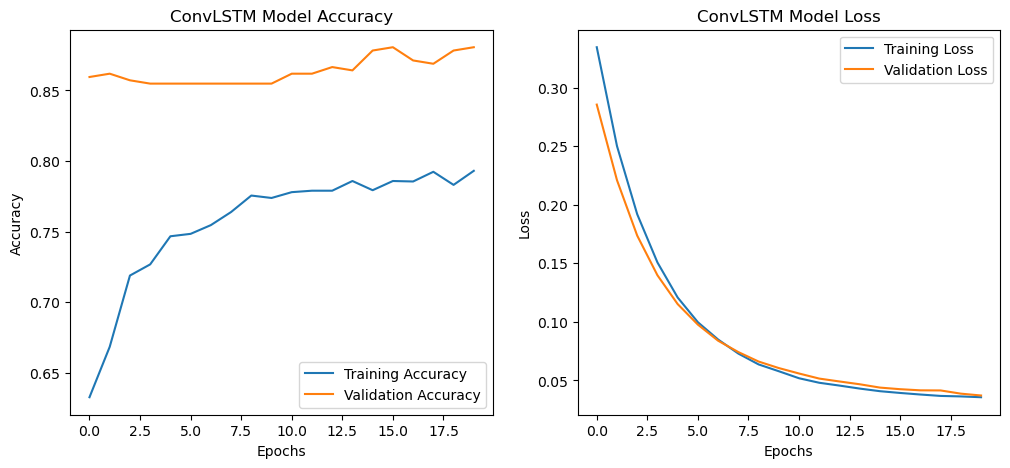

In [43]:
plt.figure(figsize=(12, 5))
#plt.title('Accuracy and Loss of ConvLSTM Model')


# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(convlstm_history.history['accuracy'], label='Training Accuracy')
plt.plot(convlstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ConvLSTM Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(convlstm_history.history['loss'], label='Training Loss')
plt.plot(convlstm_history.history['val_loss'], label='Validation Loss')
plt.title('ConvLSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


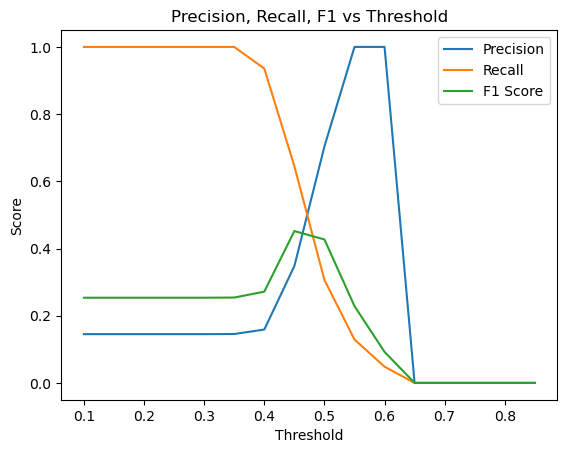

In [44]:
y_val_probs = convlstm.predict(X_val_real_reshaped)
thresholds = np.arange(0.1, 0.9, 0.05)
precisions, recalls, f1s = [], [], []

for thresh in thresholds:
    y_val_pred = (y_val_probs > thresh).astype(int)
    precisions.append(precision_score(y_val_real, y_val_pred, zero_division=0))
    recalls.append(recall_score(y_val_real, y_val_pred, zero_division=0))
    f1s.append(f1_score(y_val_real, y_val_pred, zero_division=0))

plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1 vs Threshold")
plt.legend()
plt.show()